# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma empresa de logística que cobre o Brasil inteiro. Assim como outras empresas de logística, a Loggi enfrenta problemas como: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada etc.

Os dados que serão utilizados abaixo são sintetizados de fontes públicas, como IBGE, IPEA etc., e representam os desafios que uma empresa como a Loggi enfrenta no dia a dia.

O Loggi Benckmark for Urban Deliveries (BUD) é [um repositório do Git Hub](https://github.com/loggi/loggibud) com dados e códigos que oferece a possibilidade de tornar novas soluções de pesquisa de operações mais próximas das aplicações do mundo real.

O dado bruto utilizado é um arquivo do tipo JSON que possui uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Exemplo:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...

```

Estes dados são um subconjunto dos ados originais presentes [no Git Hub da Loggi](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md) e foi consolidado por André Perez. Ele consolidou em um único arquivo as instâncias de terino de cvrp da cidade de Brasília.

## Descrição dos dados: 

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

Sendo que:

 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

## Download da base de dados

Vamos fazer o download do dado bruto que está disponível neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). O nome do arquivo é `deliveries.json`

In [1]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

## 2\. Pacotes e bibliotecas

In [2]:
!pip3 install geopandas;


In [3]:
!pip install haversine

In [4]:
import json
import numpy as np

import geopandas
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 3\. Exploração de dados

In [5]:
# Dado bruto no formato de dicionário
 
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [6]:
# Exploração inicial

len(data)

199

In [7]:
example = data[0]

In [8]:
print(example.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [9]:
example['name']

'cvrp-2-df-33'

In [10]:
example['region']

'df-2'

In [11]:
example['origin']['lat']

-15.83814451122274

In [12]:
example['origin']['lng']

-48.05498915846707

In [13]:
example['vehicle_capacity']

180

In [14]:
example['deliveries'][0]['point']['lat']

-15.848929154862294

### **3.1 Wrangling**

In [15]:
# Dado bruto no pandas

deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


*   Tanto a coluna `origin` como a coluna `deliveries` contem dados nested ou aninhados na estrutura `JSON`. Primeiro, vamos normalizar a coluna `origin` com uma operação conhecida como `flatten` ou achatamento que transforma cada chave `JSON` em uma nova coluna:

In [16]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

#Depois de realizar o achatamento, vamos juntar os dois DataFrames

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)


In [17]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Com a coluna `deliveries`, que possui uma estrutura mais complexa que `origin`, utilizaremos um outro tipo de operação conhecido como `explode`. O `explode` transforma cada elemento da lista em uma linha. Por fim, faremos o `flatten` do resultado da coluna

In [18]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda line: line["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda line: line["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda line: line["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [19]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Agora com os dados estruturados e normalizados, é interessante conhecer melhor a estrutura desse conjunto

### **3.2 Estrutura**

In [20]:
deliveries_df.shape

(636149, 8)

In [21]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [22]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [23]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


### **3.4 Schema**

In [24]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


*   Atributos **categóricos**

In [25]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


*   Atributos **numéricos**

In [26]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [27]:
# Locais mais frequentes 

locais_mais_frequentes_df = deliveries_df.groupby(['delivery_lng', 'delivery_lat'])
locais_mais_frequentes_df = locais_mais_frequentes_df.size().reset_index(name='counts')
locais_mais_frequentes_df.sort_values(by=['counts'], ascending=False).head(10)

,delivery_lng,delivery_lat,counts
195776,-47.892584,-15.817557,12
282110,-47.753464,-15.747597,10
62530,-48.054498,-16.021173,10
256421,-47.827307,-15.676228,10
148222,-47.929740,-15.797443,10
199436,-47.891135,-15.755188,9
232883,-47.875289,-15.733252,9
232907,-47.875265,-15.778612,9
275710,-47.778162,-15.778050,9
133984,-47.945338,-15.807313,9


Vemos que os locais de entrega não se repetem muito, tendo em vista que o DataFrame possui mais de 600 mil entregas

In [28]:
# Hubs com mais entregas

frequencia_hub_df = deliveries_df.groupby('region')
frequencia_hub_df = frequencia_hub_df.size().reset_index(name='counts')
frequencia_hub_df.sort_values(by=['counts'], ascending=False)


,region,counts
1,df-1,304708
2,df-2,261319
0,df-0,70122


### **3.5 Dados faltantes**

Dados faltantes podem ser:

Vazios ("");
Nulos (None);
Não disponíveis ou aplicaveis (na, NA, etc.);
Não numérico (nan, NaN, NAN, etc).

Verificando quais colunas possuem dados faltantes

In [29]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

### **4.1. Enriquecimento** 

Agora que já temos várias informações sobre nossos dados, vamos enriquecê-lo fazendo a **geocodificação reversa do hub e das entregas**

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [30]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Empresas como Google, Bing e Yahoo! fornecem **geocodificação** como serviço (e cobram por isso). Existe uma projeto *open source* chamado de [OpenStreetMap](https://www.openstreetmap.org/) que mantem um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/), serviço este que apresenta como limitação a quantia de [uma única consuta por segundo](https://operations.osmfoundation.org/policies/nominatim/). Vamos utilizá-lo através do pacote Python `geopy` para fazer a operação reversa e enriquecer o nosso DataFrame principal.

In [31]:
geolocator = Nominatim(user_agent="proj_loggi_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 68906480,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "ISO3166-2-lvl4": "BR-DF",
    "region": "Região Centro-Oeste",
    "postcod

Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [32]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [33]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [34]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [35]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Vamos fazer o merge ente o DataFrame `hub_geodata_df`, com as informações de **cidade** e **bairro**, com o DataFrame principal `deliveries_df`





In [36]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [37]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


- **Geocodificação reversa da entrega**

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) (na sua própria máquina) que pode ser utilizada sem restrição.

Os dados através do seguinte [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).

In [38]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

In [39]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [40]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol




*   **Vamos acrescentar uma coluna com a distância entre o Hub de origem e o destino das encomendas**

Para isso, utilizaremos o pacote Haversine.



In [41]:
deliveries_df["distance_hub_delivery"] = deliveries_df.index
deliveries_df["distance_hub_delivery"] = deliveries_df["distance_hub_delivery"].apply(lambda d: haversine((deliveries_df['hub_lat'][d], deliveries_df['hub_lng'][d]),
                                                                                 (deliveries_df['delivery_lat'][d], deliveries_df['delivery_lng'][d])))
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018




*   **Vamos acrescentar uma coluna com gasto de gasolina por distância percorrida**

Aqui, vamos imaginar que o veículo utilizado na entrega é um carro do modelo Fiorino Furgão 2018 1.4, que faz até 10,5km/L. Claro que o modelo do veículo utilizado pela Loggi pode ser outro. Pode ser que o veículo nem utilize gasolina, por exemplo. Pode ser um modelo que utilize alcool, gás ou disel. A ideia aqui é somente ter uma noção geral do gasto com combustível.

Segundo a Agência Nacional do Petróleo, Gás, e Biocombustíveis (ANP), o preço médio da gasolina está custando R$ 7,26 no Brasil. É em cima desse valor que vamos realizar o cálculo. 


In [42]:
deliveries_df['spent_on_gas'] = (7.26/10.5)*deliveries_df['distance_hub_delivery']

In [43]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery,spent_on_gas
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,4.601814
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,4.774598
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,4.317687
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,4.705906
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,4.687898


### **4.2. Schema** 

Vamos dar uma olhadinha na qualidade dos dados que foram acrescentados

In [44]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   name                   636149 non-null  object 
 1   region                 636149 non-null  object 
 2   hub_lng                636149 non-null  float64
 3   hub_lat                636149 non-null  float64
 4   hub_city               636149 non-null  object 
 5   hub_suburb             636149 non-null  object 
 6   vehicle_capacity       636149 non-null  int64  
 7   delivery_size          636149 non-null  int64  
 8   delivery_lng           636149 non-null  float64
 9   delivery_lat           636149 non-null  float64
 10  delivery_city          634447 non-null  object 
 11  delivery_suburb        476264 non-null  object 
 12  distance_hub_delivery  636149 non-null  float64
 13  spent_on_gas           636149 non-null  float64
dtypes: float64(6), int64(2), object(6)
m

In [45]:
deliveries_df.isna().any()

name                     False
region                   False
hub_lng                  False
hub_lat                  False
hub_city                 False
hub_suburb               False
vehicle_capacity         False
delivery_size            False
delivery_lng             False
delivery_lat             False
delivery_city             True
delivery_suburb           True
distance_hub_delivery    False
spent_on_gas             False
dtype: bool

In [46]:
def count_missing_values(vec):
    null = pd.isnull(vec)
    null_count = np.sum(null)
    return null_count

def prop_missing_values(vec):
    num = count_missing_values(vec)
    dem = vec.size
    return num / dem

def prop_complete_values(vec):
    return 1 - prop_missing_values(vec)

* **Soma dos valores ausentes**

In [47]:
count_nan = deliveries_df.apply(count_missing_values)
print(count_nan)

name                          0
region                        0
hub_lng                       0
hub_lat                       0
hub_city                      0
hub_suburb                    0
vehicle_capacity              0
delivery_size                 0
delivery_lng                  0
delivery_lat                  0
delivery_city              1702
delivery_suburb          159885
distance_hub_delivery         0
spent_on_gas                  0
dtype: int64


* **Proporção dos valores ausentes**

In [48]:
prop_nan = deliveries_df.apply(prop_missing_values)
print(prop_nan)

name                     0.000000
region                   0.000000
hub_lng                  0.000000
hub_lat                  0.000000
hub_city                 0.000000
hub_suburb               0.000000
vehicle_capacity         0.000000
delivery_size            0.000000
delivery_lng             0.000000
delivery_lat             0.000000
delivery_city            0.002675
delivery_suburb          0.251333
distance_hub_delivery    0.000000
spent_on_gas             0.000000
dtype: float64


* **Proporção dos valores não ausentes**

In [49]:
prop_complete = deliveries_df.apply(prop_complete_values)
print(prop_complete)

name                     1.000000
region                   1.000000
hub_lng                  1.000000
hub_lat                  1.000000
hub_city                 1.000000
hub_suburb               1.000000
vehicle_capacity         1.000000
delivery_size            1.000000
delivery_lng             1.000000
delivery_lat             1.000000
delivery_city            0.997325
delivery_suburb          0.748667
distance_hub_delivery    1.000000
spent_on_gas             1.000000
dtype: float64


## 5\. Visualização

*   **Mapa do Distrito Federal**









Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [50]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [51]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."




* **Mapa dos Hubs**



Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [52]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)




*   **Mapa das Entregas**



Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [53]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub_delivery,spent_on_gas,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,4.601814,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,4.774598,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,4.317687,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,4.705906,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,4.687898,POINT (-48.11490 -15.85805)




*   **Visualização**




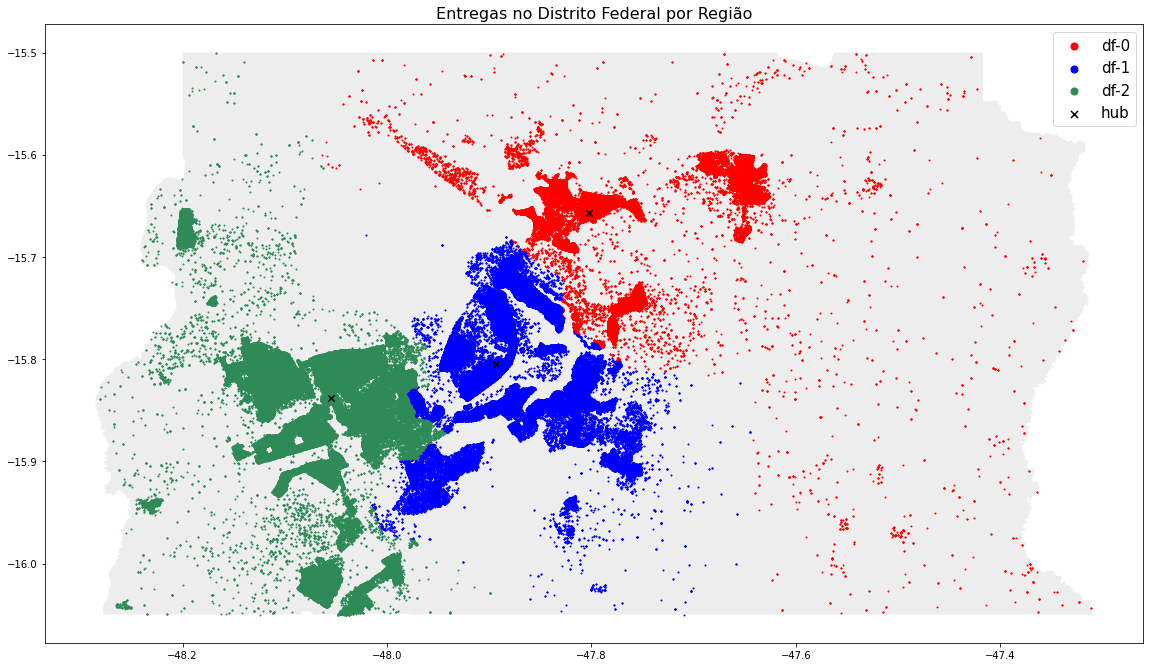

In [54]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=40, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
plt.show()

**Insights**

As entregas parecem estar corretamente alocadas em seus respectivos Hubs. No entanto, como os Hubs das regiões 0 e 2 fazem entregas em locais mais distantes do centro, isso pode gerar um tempo e preço de entrega maiores. Uma possível solução para esse problema seria redistribuir os veículos de entrega, já que as entregas dos Hubs 0 e 2 ficam mais distantes do centro de distribuição.



*   **Gráfico de entregas por região**



In [55]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()



,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


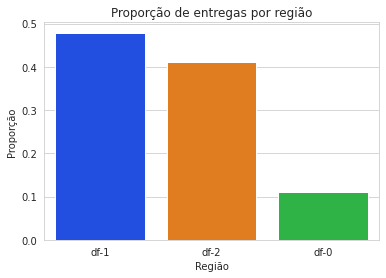

In [56]:
with sns.axes_style('whitegrid'):
    grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="bright")
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');
    

**Insights**

A distribuição das entregas está concentrada sobretudo nos Hubs 1 e 2, o que justifica a alocação de mais veículos para esses centros. No entanto, como vimos no mapa, o Hub 2 possui locais de entregas mais distantes, de modo que talvez seja necessário reavaliar a alocação de veículos entre os Hubs.







*   **Quantidade de entregas por cidade de destino**



In [57]:
data = pd.DataFrame(deliveries_df[['delivery_city']].value_counts()).reset_index()
data.rename(columns={0: "delivery_amount_per_city"}, inplace=True)
data.head()

,delivery_city,delivery_amount_per_city
0,Brasília,148983
1,Taguatinga,45564
2,Sudoeste / Octogonal,44215
3,Ceilândia,37953
4,Águas Claras,37083


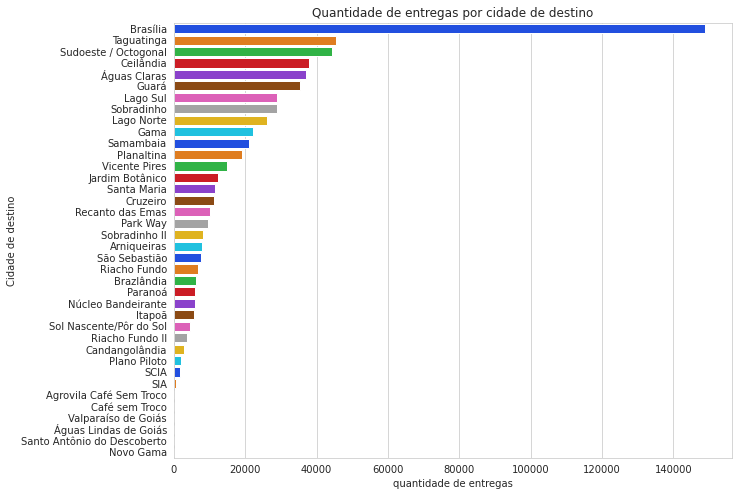

In [58]:
with sns.axes_style('whitegrid'):
  plt.subplots(figsize=(10, 8))
  grafico = sns.barplot(data=data, x="delivery_amount_per_city", y="delivery_city", ci=None, palette="bright")
  grafico.set(title='Quantidade de entregas por cidade de destino', xlabel='quantidade de entregas', ylabel='Cidade de destino');

**Insights**

Mais uma vez vemos que há uma concentração de entregas em Brasília, onde está localizado o Hub df-1. Isso justifica, de certa forma, uma concentração maior dos veículos de entrega nesse Hub. Entretanto, há também uma dispersão de entregas em outras regiões. De novo, se olharmos o mapa, vemos que o Hub de Sobradinho possui entregas distantes do centro de distribuição, ao mesmo tempo que possui menos veículos de entrega quando comparado com outros Hubs. 



*   **Média da distância entre os Hubs e os locais de entrega em Km**



In [59]:
data_mean_distance = deliveries_df[['region', 'distance_hub_delivery']].groupby('region', as_index=False).agg('mean').sort_values(by=['distance_hub_delivery'], ascending=False)
data_mean_distance = data_mean_distance.round(2)
data_mean_distance.head()

,region,distance_hub_delivery
0,df-0,9.02
2,df-2,7.90
1,df-1,5.96


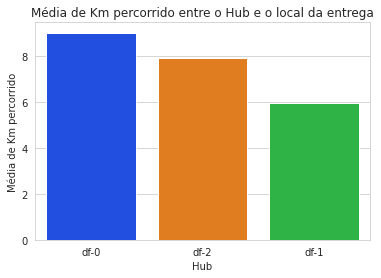

In [60]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_mean_distance, x="region", y="distance_hub_delivery", ci=None, palette="bright")
  grafico.set(title='Média de Km percorrido entre o Hub e o local da entrega', xlabel='Hub', ylabel='Média de Km percorrido');



*   **Média de gasto com gasolina por entrega**




In [61]:
data_spent_gas = deliveries_df[['region', 'spent_on_gas']].groupby('region', as_index=False).agg('mean').sort_values(by=['spent_on_gas'], ascending=False)
data_spent_gas = data_spent_gas.round(2)
data_spent_gas.head()

,region,spent_on_gas
0,df-0,6.24
2,df-2,5.46
1,df-1,4.12


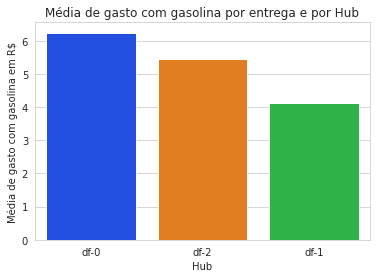

In [62]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_spent_gas, x="region", y="spent_on_gas", ci=None, palette="bright")
  grafico.set(title='Média de gasto com gasolina por entrega e por Hub', xlabel='Hub', ylabel='Média de gasto com gasolina em R$');

**Insights**

Apesar do Hub df-1 possuir mais entregas e, consequentemente, uma frota maior de veículos, o gasto com gasolina no Hub df-0 é maior e a média de km percorrido por entrega também é maior. Talvez seja necessário um remanejamento da frota, dando uma atenção maior às entregas do Hub df-0 e Hub df-2.